### 1.0 Libraries and directories

In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize

os.chdir("/Users/jmaze/Documents/geog590/")

### 2.0 Read and format the SHELDUS data

In [2]:
claims = pd.read_csv('./project_data/SC-claimsA.csv', index_col=False)

# Drop columns which we aren't using
drop_cols = [
    'StateName', 'Fatalities', 'FatalitiesDuration', 'FatalitiesPerCapita', 
    'Glide', 'Injuries', 'InjuriesDuration', 'InjuriesPerCapita', 'PropertyDmgDuration'
]

claims.drop(columns=drop_cols, inplace=True)

# Some of the column names have bad syntax
claims.rename(columns={' Hazard': 'Hazard', ' CountyName': 'CountyName'}, inplace=True)

# For the purpose of this project we'll ignore landslides. Those are predominately 
# geologic, not climate. Also, not common in SC.
claims = claims[claims['Hazard'] != 'Landslide']

# Some claims amounts are $0, this is useless for many analyses
claims = claims[claims['PropertyDmg(ADJ)'] > 0]

claims.head()

,CountyName,Hazard,EventName,StartDate,EndDate,Month,Quarter,Year,Duration_Days,CropDmg,CropDmg(ADJ),CropDmgDuration,CropDmgPerCapita,County_FIPS,Location,PropertyDmg,PropertyDmg(ADJ),PropertyDmgPerCapita,Remarks
0,Abbeville,Winter Weather,Winter Storm 1999,1999-01-02,1999-01-03,1.0,1.0,1999.0,2.0,0.0,0.0,0.0,0.0,45001.0,SCZ001>8-10>13-19,2000000.0,3614167.07,146.44,ICE STORM
1,Anderson,Winter Weather,Winter Storm 1999,1999-01-02,1999-01-03,1.0,1.0,1999.0,2.0,0.0,0.0,0.0,0.0,45007.0,SCZ001>8-10>13-19,2000000.0,3614167.07,22.20,ICE STORM
2,Cherokee,Winter Weather,Winter Storm 1999,1999-01-02,1999-01-03,1.0,1.0,1999.0,2.0,0.0,0.0,0.0,0.0,45021.0,SCZ001>8-10>13-19,2000000.0,3614167.07,72.18,ICE STORM
3,Greenville,Winter Weather,Winter Storm 1999,1999-01-02,1999-01-03,1.0,1.0,1999.0,2.0,0.0,0.0,0.0,0.0,45045.0,SCZ001>8-10>13-19,2000000.0,3614167.07,10.07,ICE STORM
4,Greenwood,Winter Weather,Winter Storm 1999,1999-01-02,1999-01-03,1.0,1.0,1999.0,2.0,0.0,0.0,0.0,0.0,45047.0,SCZ001>8-10>13-19,2000000.0,3614167.07,56.72,ICE STORM


Why is the property damage equal across counties??

A note on a flaw with SHELDUS's spatial aggregation:

“In case of multi-county events, SHELDUS™ distributes losses equally between the affected counties. For instance, a thunderstorm event affecting Richland and Lexington County in South Carolina causing property damages of 50,000 dollars will be entered into the database as an event affecting Richland County with 25,000 dollars and Lexington County with 25,000 dollars worth of damage.”

Obviously, this is not ideal... but we'll need to live with it. 

### 3.0 Plot the claims timeseries

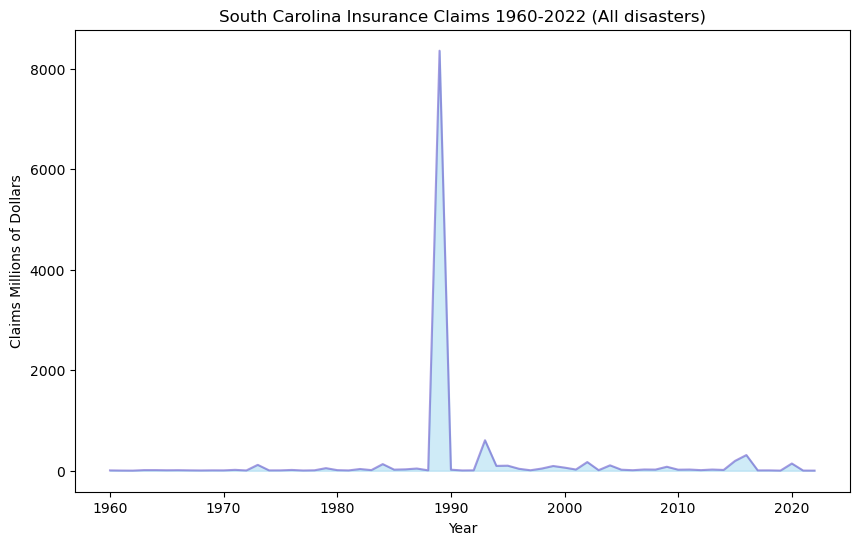

In [3]:
df = claims.groupby('Year').agg({
    'PropertyDmg(ADJ)': 'sum',
    'Year': 'first'})

plt.figure(figsize=(10, 6))
plt.fill_between(df['Year'], df['PropertyDmg(ADJ)']/1e6, color='skyblue', alpha=0.4)
plt.plot(df['Year'], df['PropertyDmg(ADJ)']/1e6, color='Slateblue', alpha=0.6)
plt.title("South Carolina Insurance Claims 1960-2022 (All disasters)")
plt.xlabel("Year")
plt.ylabel("Claims Millions of Dollars")
plt.show()

Clearly we have a few massive outlier events. Let's evaluate their impact by finding the top-5 most expensive disasters. 

#### 3.1 Inspect the worst (highest damage) events

In [4]:
worst_events = claims.groupby('EventName').agg({
    'PropertyDmg(ADJ)': 'sum'
})

total_dollars = claims['PropertyDmg(ADJ)'].sum()

worst_events['percent_all_claims_dollars'] = (
    worst_events['PropertyDmg(ADJ)'] / total_dollars * 100
)

worst_events['millions_dollars'] = worst_events['PropertyDmg(ADJ)'] / 1e6

worst_events.sort_values(
    by='percent_all_claims_dollars', 
    ascending=False, 
    inplace=True
)

worst_events = worst_events.drop(columns=['PropertyDmg(ADJ)'])

worst_events.round(2).head()

,percent_all_claims_dollars,millions_dollars
EventName,,
Hurricane 1989 Hugo,73.53,8306.40
Drought/Heatwave 1993 Southeast,4.90,553.96
Hurricane 2016 Matthew,2.71,305.70
Flooding 2015 East/SC,1.55,174.95
Severe Weather/Tornadoes Southeast/East,1.03,115.92


Wow! Out of the entire claims database, one event (Hurricane Hugo) is responsible for 73.53% of the losses (~ $8.3B adjusted to 2022 inflation). These numbers testify to the outsized impact of mega-events for insurance loss provisions. Insurers need to account for these left-tail (worst-case scenario) outcomes. There's also geographic concentration here. If an insurance company exclusively sold policies in Coastal SC in 1989, Hugo almost certianly would have bankrupted them. Policy holders would not recieve claims! This is why re-insurance companies like Swiss Re exist. They are an insurance company for the insurance companies designed to diversify geographic concentration risk.

Given my small dataset, I need to ignore Hurricane Hugo, because that event obscures all other trends. I had a wider geographic region (beyond SC), I could incorperate more outsized events; however, purchasing additional states' data from SHELDUS is prohibitively expensive. 

#### 3.2 Plot the claims timeseries without largest events

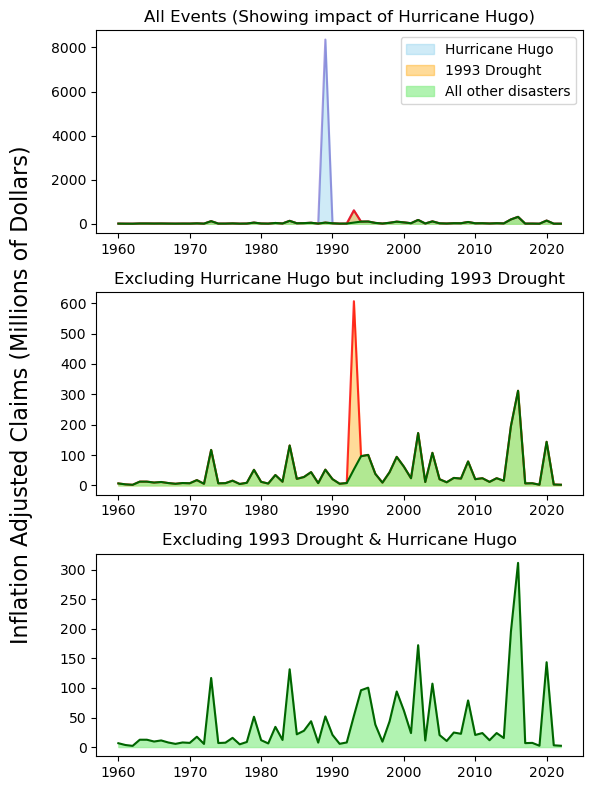

In [5]:
claims2 = claims[claims['EventName'] != "Hurricane 1989 Hugo"]
claims_noHugo = claims2.copy()

df2 = claims2.groupby('Year').agg({
    'PropertyDmg(ADJ)': 'sum',
    'Year': 'first'})

claims3 = claims[(claims['EventName'] != "Hurricane 1989 Hugo") & (claims['EventName'] != "Drought/Heatwave 1993 Southeast")]
df3 = claims3.groupby('Year').agg({
    'PropertyDmg(ADJ)': 'sum',
    'Year': 'first'})

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 8))

#First panel Includes Hugo
axs[0].fill_between(df['Year'], df['PropertyDmg(ADJ)']/1e6, color='skyblue', alpha=0.4, label='Hurricane Hugo')
axs[0].plot(df['Year'], df['PropertyDmg(ADJ)']/1e6, color='Slateblue', alpha=0.6)
axs[0].fill_between(df2['Year'], df2['PropertyDmg(ADJ)']/1e6, color='orange', alpha=0.4, label='1993 Drought')
axs[0].plot(df2['Year'], df2['PropertyDmg(ADJ)']/1e6, color='red', alpha=0.8)
axs[0].fill_between(df3['Year'], df3['PropertyDmg(ADJ)']/1e6, color='lightgreen', alpha=0.7, label='All other disasters')
axs[0].plot(df3['Year'], df3['PropertyDmg(ADJ)']/1e6, color='darkgreen', alpha=1)
axs[0].set_title("All Events (Showing impact of Hurricane Hugo)")
axs[0].legend()


# Second panel doesn't include Hugo
axs[1].fill_between(df2['Year'], df2['PropertyDmg(ADJ)']/1e6, color='orange', alpha=0.4)
axs[1].plot(df2['Year'], df2['PropertyDmg(ADJ)']/1e6, color='red', alpha=0.8)
axs[1].fill_between(df3['Year'], df3['PropertyDmg(ADJ)']/1e6, color='lightgreen', alpha=0.7)
axs[1].plot(df3['Year'], df3['PropertyDmg(ADJ)']/1e6, color='darkgreen', alpha=1)
axs[1].set_title("Excluding Hurricane Hugo but including 1993 Drought")

# Third panel doesn't include Hugo or 1993 Drought
axs[2].fill_between(df3['Year'], df3['PropertyDmg(ADJ)']/1e6, color='lightgreen', alpha=0.7)
axs[2].plot(df3['Year'], df3['PropertyDmg(ADJ)']/1e6, color='darkgreen', alpha=1)
axs[2].set_title("Excluding 1993 Drought & Hurricane Hugo")

#fig.supxlabel('Year', fontsize=16)
fig.supylabel('Inflation Adjusted Claims (Millions of Dollars)', fontsize=16)

plt.tight_layout()
plt.show()

del claims2, claims3, df2, df3

### 4.0 Reclassify Disaster Types for cleaner analysis

In [6]:
hazard_types = claims['Hazard'].unique().tolist()
print(len(hazard_types))

67


Clearly, 67 different hazard types is too many catagories to synthesize trends. Let's write a function that reclassifies these into five intuitive catagories. 

In [7]:
def hazard_broad_reclass(hazard):
    # 1. Heat, Drought and Wildfire
    if 'Heat' in hazard or 'Drought' in hazard or 'Wildfire' in hazard:
        return "Drought/Heat/Wildfire"
    # 2. Hurricanes and Tropical Storms
    if 'Hurricane' in hazard or 'Tropical Storm' in hazard:
        return "Hurricane/TropicalStorm"
    # 3. General Stormy Weather includes Tornados
    if ('Tornado' in hazard or 
        'Severe Storm' in hazard or 
        'Thunder Storm' in hazard or 
        'Hail' in hazard or
        'Wind' in hazard or
        'Flooding' in hazard or
        'Lightning' in hazard): 
        return "GeneralStorm"
    # 4. Winter Weather
    if 'Winter Weather' in hazard:
        return "WinterWeather"
    # 5. Unclassified (e.g. fog)
    else:
        return "Unclassified"

claims_noHugo['hazard_broad'] = claims_noHugo['Hazard'].apply(hazard_broad_reclass)

# Check to ensure reclass as expected. 
reclass = claims_noHugo[['Hazard', 'hazard_broad']].drop_duplicates()

total_dollars_noHugo = claims_noHugo['PropertyDmg(ADJ)'].sum()
hazard_categories = ['Drought/Heat/Wildfire', 'Hurricane/TropicalStorm', 'GeneralStorm', 'WinterWeather', 'Unclassified']
percentages = {}

for category in hazard_categories:
    category_claims = claims_noHugo['PropertyDmg(ADJ)'][claims_noHugo['hazard_broad'] == category].sum()
    category_perc = category_claims / total_dollars_noHugo * 100
    percentages[category] = category_perc

# Print the percentages
for category, perc in percentages.items():
    print(f'{perc:.2f} % {category}')


21.63 % Drought/Heat/Wildfire
14.30 % Hurricane/TropicalStorm
51.83 % GeneralStorm
12.10 % WinterWeather
0.14 % Unclassified


# Is doing boolean variables a better options??

### 5.0 Plot the distribution of distasters.

#### 5.1 Plot the distribution of all disasters (ex-Hugo).

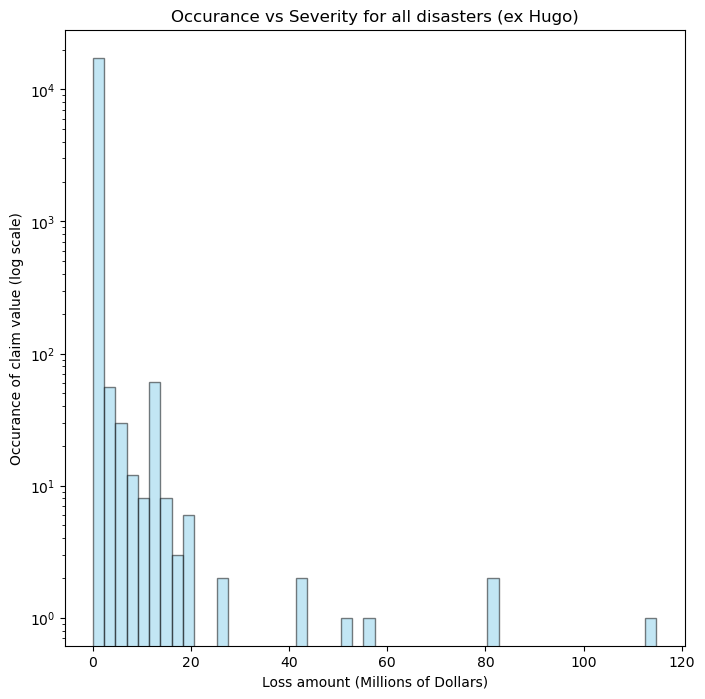

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.hist(claims_noHugo['PropertyDmg(ADJ)'] / 1e6, bins=50, color='skyblue', alpha=0.5, edgecolor='black')
ax.set_yscale('log')
ax.set_ylabel('Occurance of claim value (log scale)')
ax.set_xlabel('Loss amount (Millions of Dollars)') 
ax.set_title('Occurance vs Severity for all disasters (ex Hugo)')
plt.show()


#### 5.2 Plot the distributions based on disaster type. 

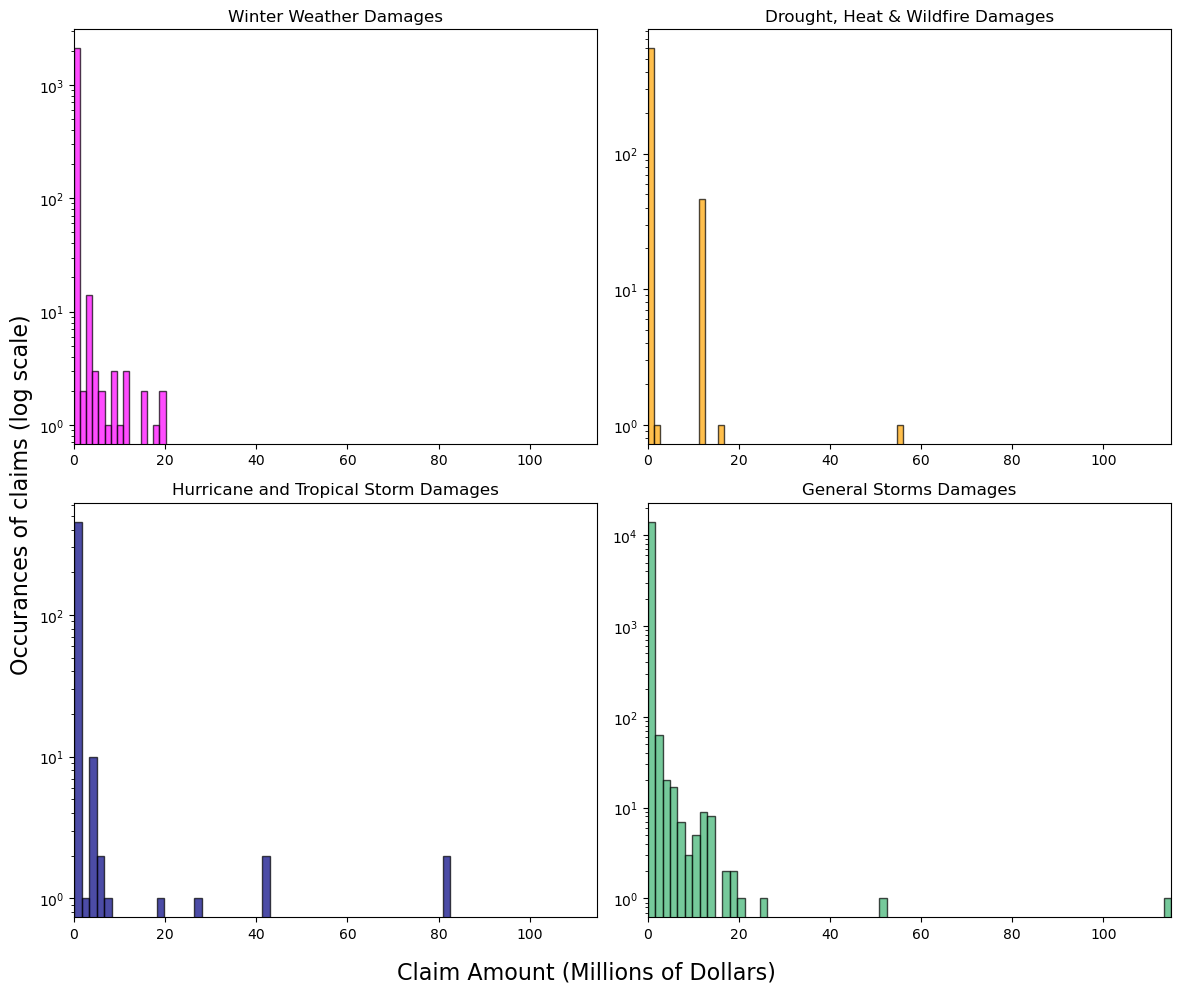

In [9]:
winter_weather = claims_noHugo[claims_noHugo['hazard_broad'] == 'WinterWeather'].copy()
drought_heat_wildfire = claims_noHugo[claims_noHugo['hazard_broad'] == 'Drought/Heat/Wildfire'].copy()
hurricanes = claims_noHugo[claims_noHugo['hazard_broad'] == "Hurricane/TropicalStorm"].copy()
generalstorms = claims_noHugo[claims_noHugo['hazard_broad'] == "GeneralStorm"].copy()


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

colors = ['magenta', 'orange', 'navy', 'mediumseagreen']

axs[0, 0].hist(winter_weather['PropertyDmg(ADJ)']/1e6, bins=15, alpha = 0.7, color=colors[0], edgecolor='black')
axs[0, 0].set_yscale('log')
axs[0, 0].set_title('Winter Weather Damages')

axs[0, 1].hist(drought_heat_wildfire['PropertyDmg(ADJ)']/1e6, bins=40, alpha = 0.7, color=colors[1], edgecolor='black')
axs[0, 1].set_yscale('log')
axs[0, 1].set_title('Drought, Heat & Wildfire Damages')

axs[1, 0].hist(hurricanes['PropertyDmg(ADJ)']/1e6, bins=50, alpha = 0.7, color=colors[2], edgecolor='black')
axs[1, 0].set_yscale('log')
axs[1, 0].set_title('Hurricane and Tropical Storm Damages')

axs[1, 1].hist(generalstorms['PropertyDmg(ADJ)']/1e6, bins=70, alpha = 0.7, color=colors[3], edgecolor='black')
axs[1, 1].set_yscale('log')
axs[1, 1].set_title('General Storms Damages')

x_limits = [0, max(claims_noHugo['PropertyDmg(ADJ)']) / 1e6]
for ax in axs.flat:
    ax.set_xlim(x_limits)
    
fig.supxlabel('Claim Amount (Millions of Dollars)', fontsize=16)
fig.supylabel('Occurances of claims (log scale)', fontsize=16)

plt.tight_layout()
plt.show()

### 6.0 Merge county shapefiles for GeoDataFrame

In [10]:
counties = gpd.read_file('./project_data/county_shapefiles/tl_2021_us_county.shp')
counties = counties.query("STATEFP == '45'")

# Convert FIPS to characters for merging.
claims_noHugo['County_FIPS'] = claims_noHugo['County_FIPS'].astype(int).astype(str)

claims_gdf = pd.merge(
    claims_noHugo, 
    counties[['GEOID', 'geometry']], 
    left_on=['County_FIPS'], 
    right_on=['GEOID'], how='left'
    )

claims_gdf = claims_gdf.set_geometry('geometry')

### 7.0 Make Chloropleth Maps

#### 7.1 Map for all damages

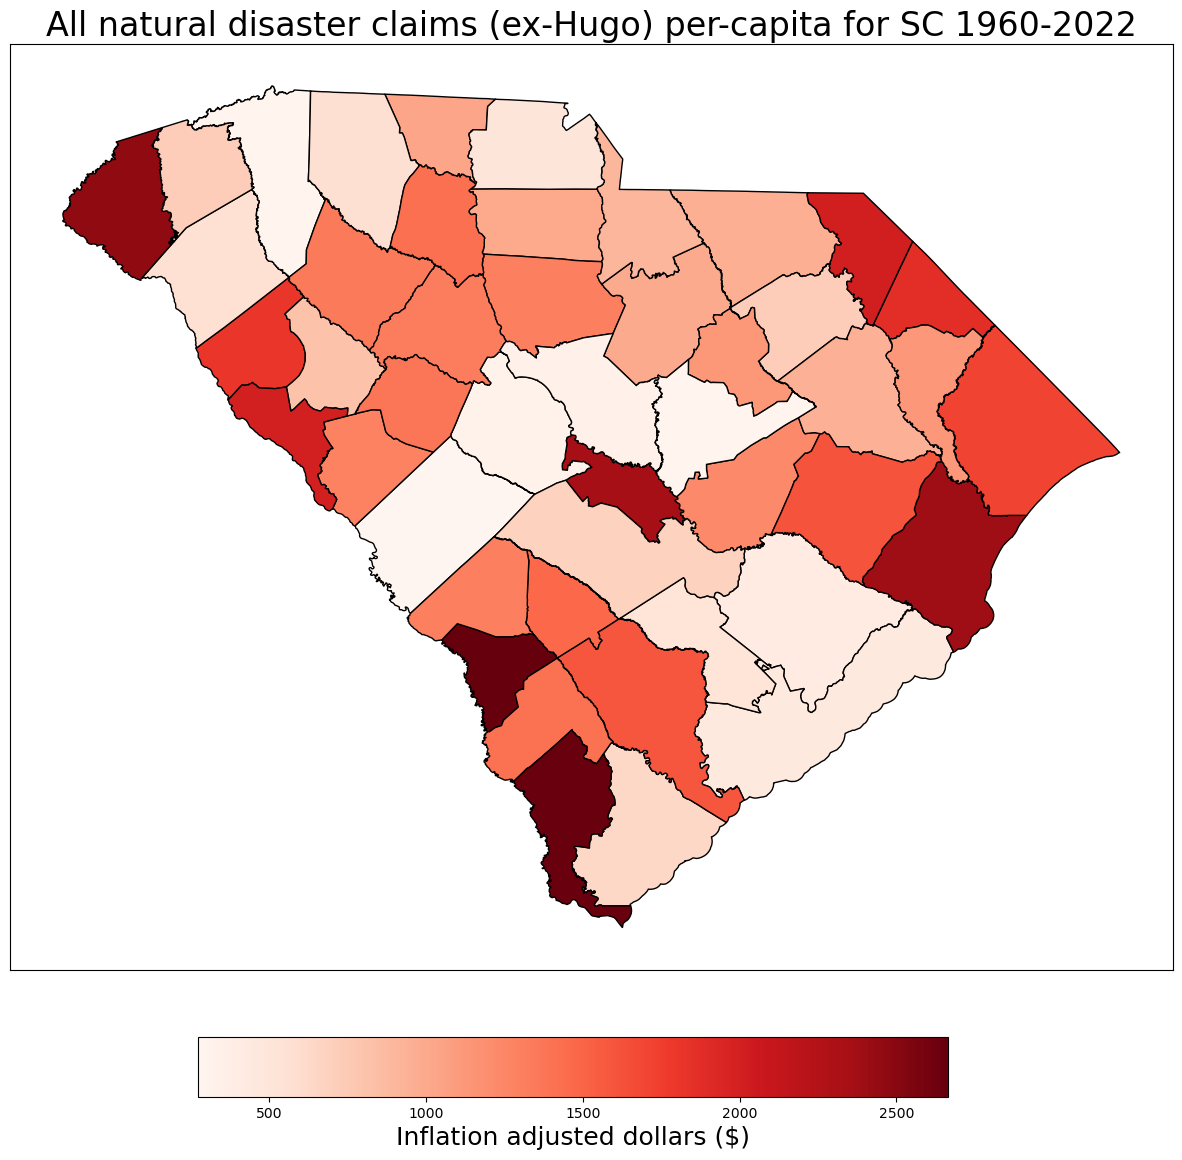

In [11]:
# Prepare data for plot
gdf_temp = claims_gdf.groupby('County_FIPS').agg({
    'PropertyDmgPerCapita': 'sum',
    'CountyName': 'first',
    'geometry': 'first'
}).reset_index()
gdf_temp = gdf_temp.set_geometry('geometry')
gdf_temp = gdf_temp.set_crs(counties.crs)

# Render the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 20))

gdf_temp.plot(column='PropertyDmgPerCapita', ax=ax, cmap='Reds', edgecolor='black')

cax = fig.add_axes([0.25, 0.2, 0.5, 0.03])
sm = plt.cm.ScalarMappable(
    cmap='Reds', 
    norm=plt.Normalize(vmin=gdf_temp['PropertyDmgPerCapita'].min(), 
                       vmax=gdf_temp['PropertyDmgPerCapita'].max()
                       )
    )

sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Inflation adjusted dollars ($)', fontsize=18)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('All natural disaster claims (ex-Hugo) per-capita for SC 1960-2022', fontsize=24)

plt.show()

del gdf_temp

#### 7.2 Map of most destructive disaster type by county

/var/folders/r4/sjvm2l157p7_b2k23_h5tw1r0000gq/T/ipykernel_6043/1222221938.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_temp2['centroid'] = gdf_temp2.geometry.centroid


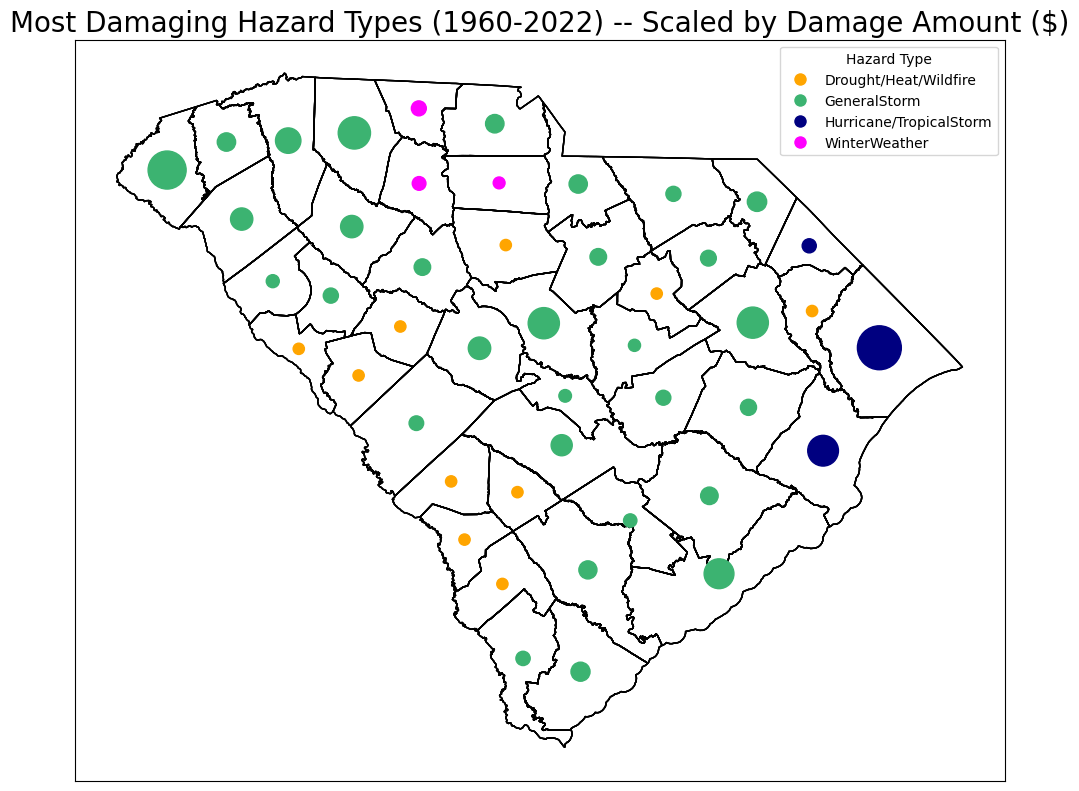

In [14]:
gdf_temp = claims_gdf.groupby(['County_FIPS', 'hazard_broad']).agg(
    total_dmg_adj=('PropertyDmg(ADJ)', 'sum'),
    geometry=('geometry', 'first')
).reset_index()
gdf_temp = gdf_temp.set_geometry('geometry')
gdf_temp = gdf_temp.set_crs(counties.crs)

# Group by county FIPS and return the maximum damage column
gdf_temp2 = gdf_temp.loc[gdf_temp.groupby('County_FIPS')['total_dmg_adj'].idxmax()]


gdf_temp2['centroid'] = gdf_temp2.geometry.centroid

gdf_temp2 = gpd.GeoDataFrame(gdf_temp2, geometry='centroid')

# Assign the colors to hazard type for plotting
colors = ['orange', 'mediumseagreen', 'navy', 'magenta']
hazards = sorted(gdf_temp2['hazard_broad'].unique().tolist())
color_map = {category: colors[i % len(colors)] for i, category in enumerate(hazards)}

# Map colors to gdf
gdf_temp2['color'] = gdf_temp2['hazard_broad'].map(color_map)

fig, ax = plt.subplots(figsize=(12, 12))
gdf_temp['geometry'].plot(ax=ax, edgecolor='black', facecolor='none')
gdf_temp2.plot(
    ax=ax,
    color=gdf_temp2['color'],
    markersize=gdf_temp2['total_dmg_adj'] / gdf_temp2['total_dmg_adj'].max() * 1000,
    legend='True'
)

ax.set_xticks([])
ax.set_yticks([])

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cat], markersize=10) for cat in hazards]
labels = hazards
ax.legend(handles, labels, title='Hazard Type')
ax.set_title('Most Damaging Hazard Types (1960-2022) -- Scaled by Damage Amount ($)', size=20)

plt.show()

#### 7.3 Make a stacked barchart reflecting map values

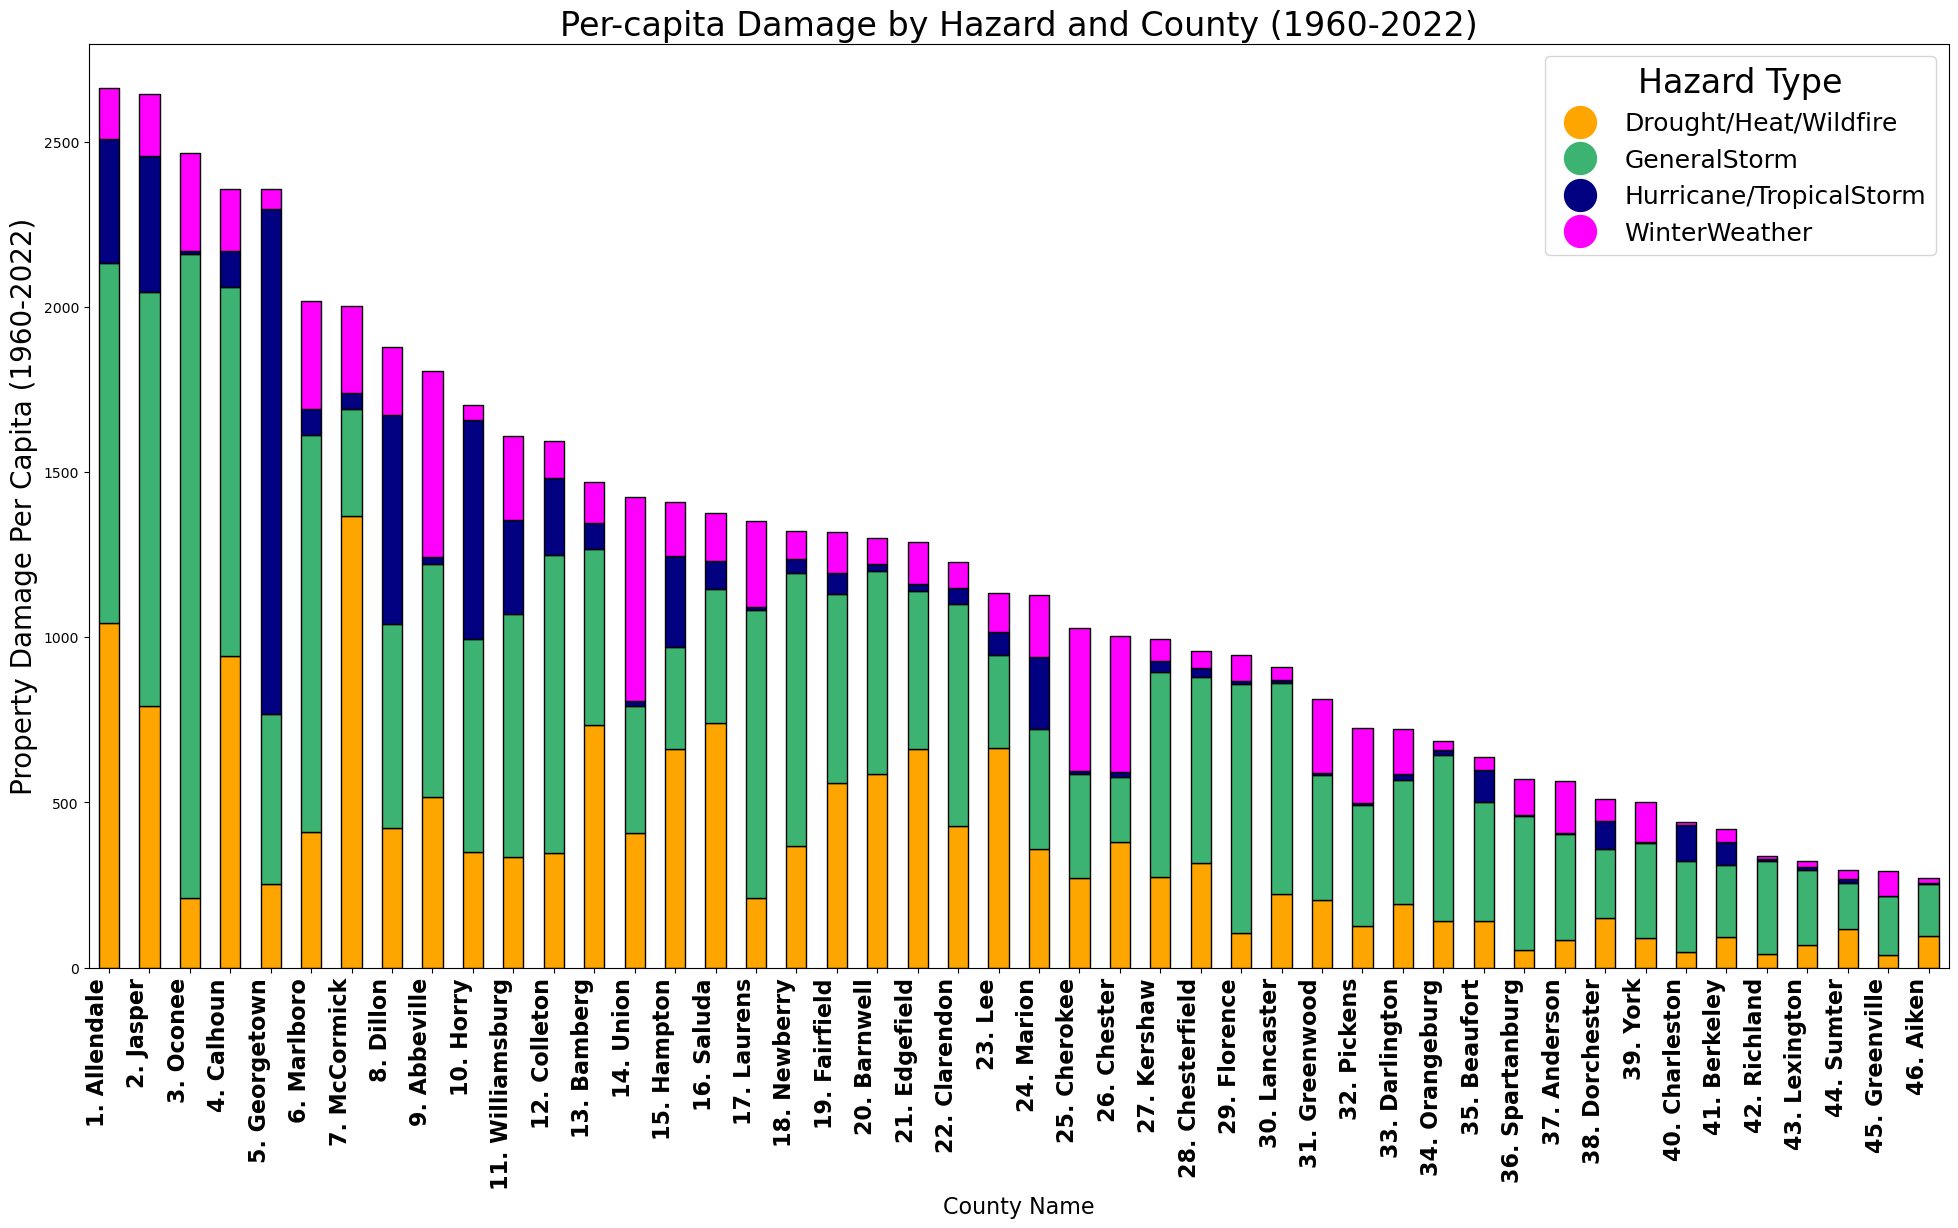

In [15]:
grouped = claims_gdf.groupby(['CountyName', 'hazard_broad'])['PropertyDmgPerCapita'].sum().unstack()
grouped.drop(columns=['Unclassified'], inplace=True)

grouped['Total'] = grouped.sum(axis=1)

# Sort the DataFrame by the 'Total' column in descending order
grouped = grouped.sort_values(by='Total', ascending=False)

# Drop the 'Total' column after sorting
grouped = grouped.drop(columns=['Total'])


bar_colors = [color_map[hazard] for hazard in grouped.columns]

# Plotting
fig, ax = plt.subplots(figsize=(24, 12))
grouped.plot(kind='bar', stacked=True, ax=ax, color=bar_colors, edgecolor='black')

numbered_counties = [f"{i+1}. {county}" for i, county in enumerate(grouped.index)]

# Adding labels and title
plt.xlabel('County Name', fontsize=16)
ax.set_xticklabels(numbered_counties, rotation=90, ha='right', fontsize=16, fontweight='bold')
plt.ylabel('Property Damage Per Capita (1960-2022)', fontsize=20)
plt.title('Per-capita Damage by Hazard and County (1960-2022)', fontsize=24)
ax.legend(handles, labels, title='Hazard Type', title_fontsize='24', fontsize='18', markerscale=2.5)
plt.show()


#### 7.4 Difference in claims (1960-1991 vs 1992-2022)

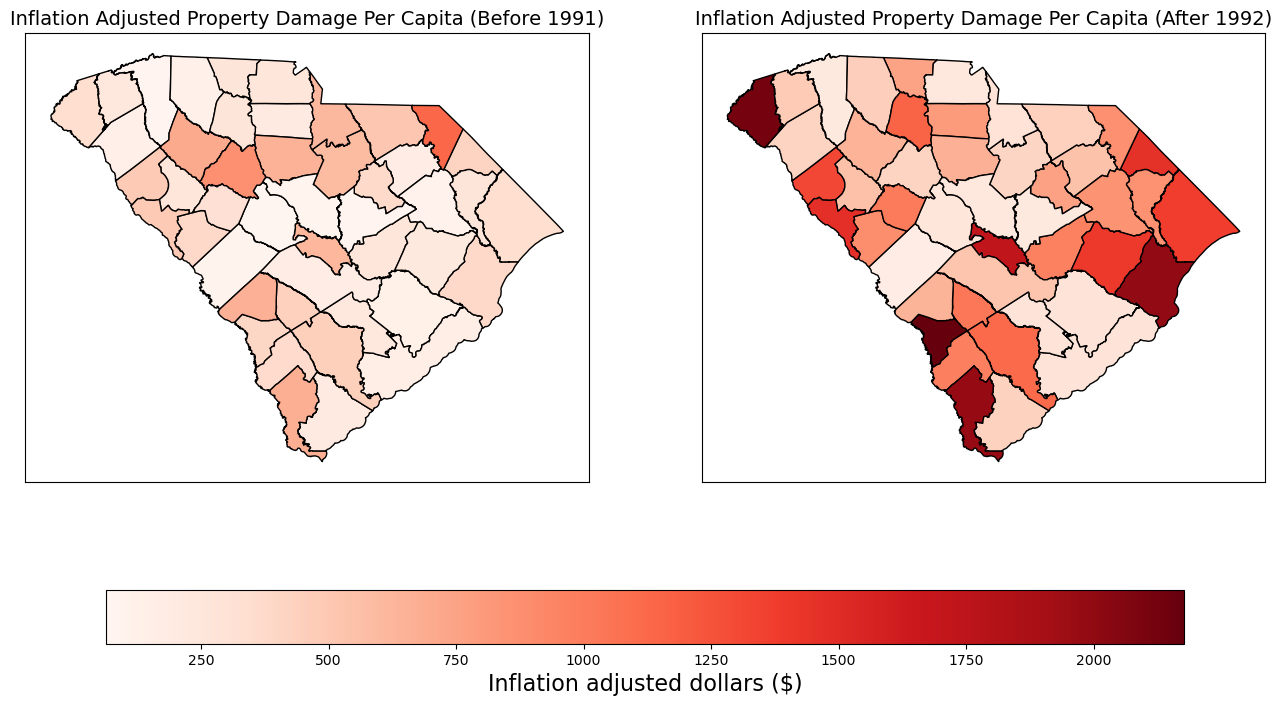

In [16]:
gdf_temp1 = claims_gdf[claims_gdf['Year'] < 1991]

gdf_temp1 = gdf_temp1.groupby('County_FIPS').agg({
    'PropertyDmgPerCapita': 'sum',
    'CountyName': 'first',
    'geometry': 'first'
}).reset_index()

gdf_temp1 = gdf_temp1.set_geometry('geometry')
gdf_temp1 = gdf_temp1.set_crs(counties.crs)

gdf_temp2 = claims_gdf[claims_gdf['Year'] > 1992]
gdf_temp2 = gdf_temp2.groupby('County_FIPS').agg({
    'PropertyDmgPerCapita': 'sum',
    'CountyName': 'first',
    'geometry': 'first'
}).reset_index()

gdf_temp2 = gdf_temp2.set_geometry('geometry')
gdf_temp2 = gdf_temp2.set_crs(counties.crs)


# Make the comparison plot
fig, axs = plt.subplots(1, 2, figsize=(16, 14))

vmin = min(gdf_temp1['PropertyDmgPerCapita'].min(), gdf_temp2['PropertyDmgPerCapita'].min())
vmax = max(gdf_temp1['PropertyDmgPerCapita'].max(), gdf_temp2['PropertyDmgPerCapita'].max())
norm = Normalize(vmin=vmin, vmax=vmax)


# Plotting the GeoDataFrames on the respective axes
gdf_temp1.plot(column='PropertyDmgPerCapita', ax=axs[0], cmap='Reds', edgecolor='black', norm=norm)
gdf_temp2.plot(column='PropertyDmgPerCapita', ax=axs[1], cmap='Reds', edgecolor='black', norm=norm)

# Adding titles to the subplots
axs[0].set_title('Inflation Adjusted Property Damage Per Capita (Before 1991)', fontsize=14)
axs[1].set_title('Inflation Adjusted Property Damage Per Capita (After 1992)', fontsize=14)

# Add a color bar 
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'), 
                    ax=axs, 
                    orientation='horizontal', 
                    fraction=0.05, 
                    pad=0.1
)
cbar.set_label('Inflation adjusted dollars ($)', fontsize=16)

# Adding axis titles
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
#axs[0].set_xlabel('Longitude')
#axs[0].set_ylabel('Latitude')
#axs[1].set_xlabel('Longitude')
#axs[1].set_ylabel('Latitude')

plt.show()

del gdf_temp1, gdf_temp2


Wow! There appears to be an alarming increase; however, there are two key data artifacts amplifying the trends. 

 1) "NCEI’s Online Storm Data dates back to 1960 for tornadoes, thunderstorm wind, and hail only. Reporting for all other NCEI Online Storm Data hazards begins in 1996."
 2) "between 1960 and 1995, NCDC’s Storm Data provided logarithmic loss estimates (50, 50-500, 500-5000, 50,000-500,000, 5,000,000-50,000,000, etc.) instead of a specific estimate. SHELDUS™ applies conservative estimates to losses. Whenever losses are reported as a range (e.g., 5,000 to 50,000), SHELDUS™ selects the lower bound of the range (e.g., 5,000). NCEI reports all events prior to 1994/95 as a range. NCEI’s Online Storm Data offers the midpoint of such a loss range (e.g., 25,000) resulting in a seemingly higher loss than what is reported in SHELDUS™"

This means analyzing data across these methodological changes inherently flawed. 


### Storm Damages Per-capita change

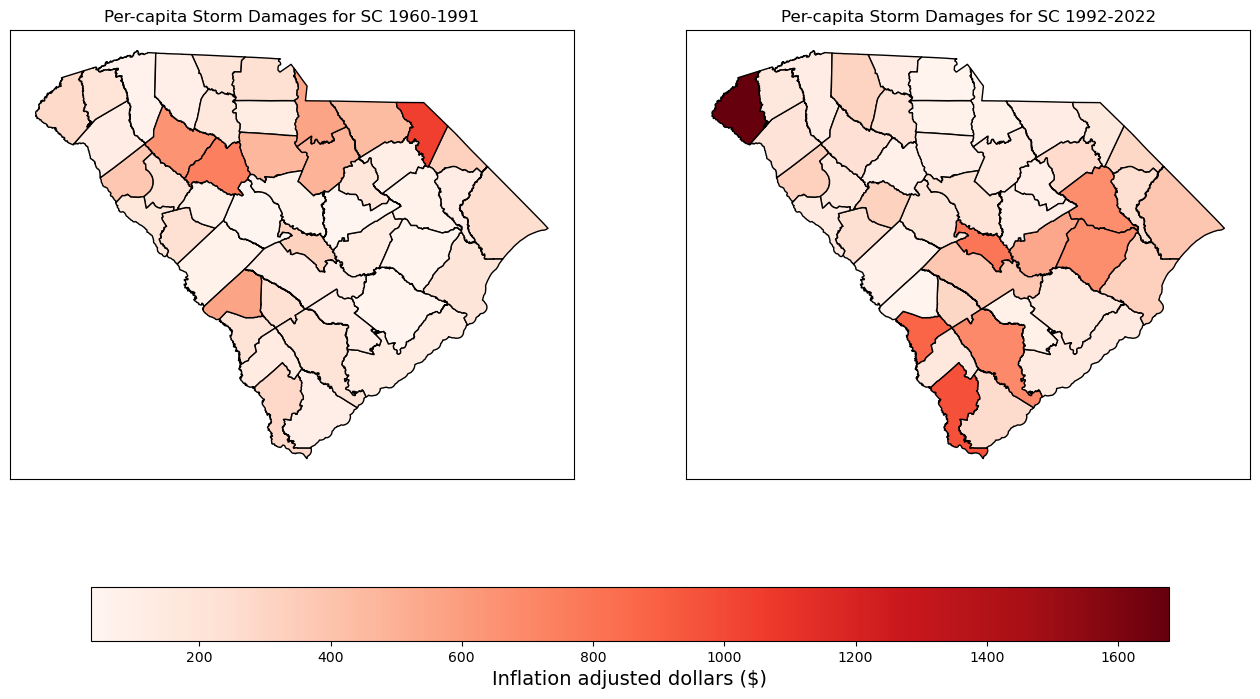

In [17]:
gdf_temp = claims_gdf[claims_gdf['hazard_broad'] == 'GeneralStorm']

gdf_temp1 = gdf_temp[gdf_temp['Year'] < 1991]

gdf_temp1 = gdf_temp1.groupby('County_FIPS').agg({
    'PropertyDmgPerCapita': 'sum',
    'CountyName': 'first',
    'geometry': 'first'
}).reset_index()

gdf_temp1 = gdf_temp1.set_geometry('geometry')
gdf_temp1 = gdf_temp1.set_crs(counties.crs)

gdf_temp2 = gdf_temp[gdf_temp['Year'] >= 1991]
gdf_temp2 = gdf_temp2.groupby('County_FIPS').agg({
    'PropertyDmgPerCapita': 'sum',
    'CountyName': 'first',
    'geometry': 'first'
}).reset_index()

gdf_temp2 = gdf_temp2.set_geometry('geometry')
gdf_temp2 = gdf_temp2.set_crs(counties.crs)


# Make the comparison plot
fig, axs = plt.subplots(1, 2, figsize=(16, 14))

vmin = min(gdf_temp1['PropertyDmgPerCapita'].min(), gdf_temp2['PropertyDmgPerCapita'].min())
vmax = max(gdf_temp1['PropertyDmgPerCapita'].max(), gdf_temp2['PropertyDmgPerCapita'].max())
norm = Normalize(vmin=vmin, vmax=vmax)


# Plotting the GeoDataFrames on the respective axes
gdf_temp1.plot(column='PropertyDmgPerCapita', ax=axs[0], cmap='Reds', edgecolor='black', norm=norm)
gdf_temp2.plot(column='PropertyDmgPerCapita', ax=axs[1], cmap='Reds', edgecolor='black', norm=norm)

# Adding titles to the subplots
axs[0].set_title('Per-capita Storm Damages for SC 1960-1991', fontsize=12)
axs[1].set_title('Per-capita Storm Damages for SC 1992-2022', fontsize=12)

# Add a color bar 
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'), 
                    ax=axs, 
                    orientation='horizontal', 
                    fraction=0.05, 
                    pad=0.1
)
cbar.set_label('Inflation adjusted dollars ($)', fontsize=14)

# Adding axis titles
# Adding axis titles
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.show()

In [26]:
claims_noHugo.to_csv('./project_data/claims_v2.csv', index=False)